In [1]:
%reload_ext autoreload
%autoreload 2
# !pip install --upgrade transformers 
# which python
# !pip install -q transformers
# !pip install -q datasets
# !pip install -q evaluate
# !pip install -q accelerate
# !pip install -q gluonts ujson

# Tutoial directly gotten from https://huggingface.co/blog/time-series-transformers


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

df = pd.read_csv("../../datasets/household_power_consumption.txt", sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
print("Length of dataset", len(df))
print(df.head())
df.describe()

Length of dataset 2075259
                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
200

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [3]:
# filling nan with mean in any columns
print("Before:",df.isnull().sum())
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
print("After:", df.isnull().sum())

Before: Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
After: Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [4]:
# here we split the data into different granularity (hours, days, weeks, months)
df_minute = df
df_hours = df.resample("h").mean()
df_days = df.resample("D").mean()
df_weeks = df.resample("W").mean()
df_months = df.resample("M").mean()
print("Length of minute dataset:", len(df_minute))
print("Length of hours dataset:", len(df_hours))
print("Length of days dataset:", len(df_days))
print("Length of weeks dataset:", len(df_weeks))
print("Length of months dataset:", len(df_months))

# print("---MINUTE---")
# print(df_minute.head())
# print("---HOURS---")
# print(df_hours.head())
print("---DAYS---")
print(df_days.head())
# print("---WEEKS---")
# print(df_weeks.head())
# print("---MONTHS---")
# print(df_months.head())
print(df_days.keys())

Length of minute dataset: 2075259
Length of hours dataset: 34589
Length of days dataset: 1442
Length of weeks dataset: 207
Length of months dataset: 48
---DAYS---
            Global_active_power  Global_reactive_power     Voltage  \
dt                                                                   
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
dt                                                                            
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667  

In [5]:
from gluonts.dataset.common import ListDataset
# Data splitting 
from gluonts.dataset.field_names import FieldName
from sklearn.preprocessing import MinMaxScaler
# Choosing prediction column 
n_cols = 1
# For now I am only using Global_active_power to predict Global_active_power (days)
# dataset = df["Global_active_power"]
dataset = df_days["Global_active_power"]
# dataset = df_hours["Global_active_power"]
dataset = pd.DataFrame(dataset)

# All the hyperparameters here including the patch sizes are the same as delhi.ipynb just to keep things consistent
data = dataset.values
scaler = MinMaxScaler(feature_range= (0, 1))
# scaled_data = scaler.fit_transform(np.array(data))

scaled_data = np.array(data)
scaled_data = scaled_data.reshape(scaled_data.shape[0])
train_size = int(len(scaled_data) * 0.5)
val_size = int(0.75 * len(scaled_data)) - train_size
train_data = scaled_data[0:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]
prediction_length = 24 # 24 days 
freq = "1D" # set frequency to 1 day
# target, feat_dynamic_real, feat_static_cat = data_out
def getTarget(patch, stride, data_list):
    
    target = []
    for i in range(patch, len(data_list), stride):
        target.append(data_list[i-patch:i])
    # Convert to numpy array
    target = np.array(target)
    # Reshaping the input to (n_samples, time_steps, n_feature)
    # target = np.reshape(target, (target.shape[0], target.shape[1], n_cols))
    return target
# TODO: why is the start date not changing? MIGHT NEED TO FIX
train_target = getTarget(7 * 24, 1, train_data)
feat_static_cat = [i for i in range(len(train_target))]
train_start =  [pd.Period("16-12-2006", freq=freq) for _ in range(len(train_target))]
print(train_target.shape)
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            train_target[:, :-prediction_length],
            train_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)

val_target = getTarget(7 * 24, 1, val_data)
val_start =  [pd.Period("06-12-2008", freq=freq) for _ in range(len(val_target))]
val_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            val_target[:, :-prediction_length],
            val_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)


test_target = getTarget(7 * 24, 1, test_data)
test_start =  [pd.Period("01-12-2009", freq=freq) for _ in range(len(test_target))] 
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_STATIC_CAT: [fsc],
        }
        for (target, start, fsc) in zip(
            test_target[:, :-prediction_length],
            test_start,
            feat_static_cat,
        )
    ],
    freq=freq,
)
print(len(test_ds), len(test_ds[0]["target"]))

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3382: UserWarning: Parsing '16-12-2006' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  if await self.run_code(code, result, async_=asy):


(553, 168)
193 144


In [6]:
# train_example = dataset['train'][0]
# print(train_example.keys())
# validation_example = dataset['validation'][0]
# test_example = dataset['test'][0]
# print(dataset['train'][0]["start"])
# print(len(dataset['train'][0]["target"]))
# print(dataset['train'][4]["start"])
# print(len(dataset['train'][4]["target"]))

In [7]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [8]:
train_dataset = train_ds
val_dataset = val_ds
test_dataset = test_ds

    
freq = "1D"


In [9]:
# from functools import partial
# from datasets import load_dataset

# dummy_dataset = load_dataset("monash_tsf", "tourism_monthly")

# train_dataset = dummy_dataset["train"]
# val_dataset = dummy_dataset["validation"]
# test_dataset = dummy_dataset["test"]
# freq = "1M"
# train_dataset.set_transform(partial(transform_start_field, freq=freq))
# val_dataset.set_transform(partial(transform_start_field, freq=freq))
# test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [10]:
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str

# The look back window, in this case how many days we consider 
# lags_sequence = get_lags_for_frequency(freq)
lags_sequence = get_lags_for_frequency(freq)[:19]
time_features = time_features_from_frequency_str(freq)

print(lags_sequence)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31]
[<function day_of_week at 0x0000018036E24700>, <function day_of_month at 0x0000018036E24820>, <function day_of_year at 0x0000018036E24940>]


In [11]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # # How many inputs the model take into account when 
    context_length=prediction_length * 2, 
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,# TODO: understand this 
    # day of year, day of months, and day of week
    num_time_features=len(time_features),
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],# TODO: understand this 
    scaling = "std",
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32, 
    num_parallel_samples = 1 # default
    
)

model = TimeSeriesTransformerForPrediction(config)

c:\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # We use days of week, days of months, and days of years in this case 
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            # AddAgeFeature(
            #     target_field=FieldName.TARGET,
            #     output_field=FieldName.FEAT_AGE,
            #     pred_length=config.prediction_length,
            #     log_scale=True,
            # ),
            # # step 6: vertically stack all the temporal features into the key FEAT_TIME
            # VstackFeatures(
            #     output_field=FieldName.FEAT_TIME,
            #     input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
            #     + (
            #         [FieldName.FEAT_DYNAMIC_REAL]
            #         if config.num_dynamic_real_features > 0
            #         else []
            #     ),
            # ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )
    
    
    
# transformation = create_transformation(freq, config)
# transformed_data = transformation.apply(train_dataset, is_train=False)
# print(next(iter(transformed_data))["time_features"].shape)
# print(train_dataset[0].keys())

# print(next(iter(transformed_data))["time_features"][0])
# # print(train_dataset[0]["target"])
# time_features_from_frequency_str(freq)[0](train_dataset[0]["start"])

In [13]:


from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches

def create_dataloader(
    type_ : str, 
    is_train: bool,
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=is_train)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, type_)

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=is_train
    )
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )
    
    
    
    
    
def create_val_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a val Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "validation")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [14]:
train_dataloader = create_dataloader(
    "train",
    True,
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

val_dataloader1 = create_dataloader(
    "validation",
    False,
    config=config,
    freq=freq,
    data=val_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader1 = create_dataloader(
    "test",
    False,
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)
i = 0
for j in train_dataloader:
    i+=1
    print(len(j["past_values"][0]))
    print(len(j["future_values"][0]))
    break

i = 0
for j in val_dataloader1:
    i+=1
    print(len(j["past_values"][0]))
    print(len(j["future_values"][0]))
    break

i = 0
for j in test_dataloader1:
    i+=1
    print(len(j["past_values"][0]))
    print(len(j["future_values"][0]))
    break
    # print(j["past_values"])

79
24
79
24
79
0


In [15]:

batch = next(iter(train_dataloader))
# perform forward pass
print(batch.keys())
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
# dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])

model.eval()
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)
print("Loss:", outputs.loss.item())


dict_keys(['past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'static_categorical_features', 'future_values', 'future_observed_mask'])
Loss: 0.4269823133945465


In [16]:
from accelerate import Accelerator
from torch.optim import AdamW
import torch.optim.lr_scheduler as lr_scheduler
from evaluate import load
from gluonts.time_feature import get_seasonality
from IPython.display import clear_output
import os 

accelerator = Accelerator()
device = accelerator.device

def train(model, train_data_loader, val_data_loader, test_data_loader, epoch, lr, weight_decay, encoder_layers, decoder_layers, d_model):
    model.to(device)
    # path_prefix = f"saved_models/{str(lr)}-{str(weight_decay)}-{str(encoder_layers)}-{str(decoder_layers)}-{str(d_model)}/"
    path_prefix = f"saved_models/{str(lr)}-{str(weight_decay)}-{str(encoder_layers)}-{str(decoder_layers)}-{str(d_model)}/"
    # Check if the folder exists, and create it if it doesn't
    if not os.path.exists(path_prefix + "state/"):
        print("creating new path " + path_prefix + "state/")
        os.makedirs(path_prefix + "state/")
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    model, optimizer, train_data_loader, val_data_loader, test_data_loader = accelerator.prepare(
        model,
        optimizer,
        train_data_loader,
        val_data_loader,
        test_data_loader,
    )
    model.train()
    best_train_score = float("infinity")
    best_train_epoch = -1
    best_val_score = float("infinity")
    best_val_epoch = -1 
    print("-------------TRAINING START-------------")
    print("Training with epoch: " + str(epoch))
    train_losses, val_losses, test_losses = [], [], []  
    epoch_list = []
    for ep in range(epoch):
        model.train()
        curLoss, i = 0, 0
        for idx, batch in enumerate(train_data_loader):
            optimizer.zero_grad()
            outputs = model(
                static_categorical_features=batch["static_categorical_features"].to(device)
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"].to(device)
                if config.num_static_real_features > 0
                else None,
                past_time_features=batch["past_time_features"].to(device),
                past_values=batch["past_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_observed_mask=batch["future_observed_mask"].to(device),
            )
            loss = outputs.loss
            curLoss += loss.item()
            # Backpropagation
            accelerator.backward(loss)
            optimizer.step()
            i += 1 
            if idx % 100 == 0:
                print(loss.item())
        train_losses.append(curLoss / i)
        if train_losses[-1] < best_train_score:
            best_train_score = train_losses[-1]
            best_train_epoch = ep 
        scheduler.step()
        
        model.eval()
        with torch.no_grad():
            
            curLoss, i = 0, 0
            for idx, batch in enumerate(val_data_loader):
                optimizer.zero_grad()
                outputs = model(
                    static_categorical_features=batch["static_categorical_features"].to(device)
                    if config.num_static_categorical_features > 0
                    else None,
                    static_real_features=batch["static_real_features"].to(device)
                    if config.num_static_real_features > 0
                    else None,
                    past_time_features=batch["past_time_features"].to(device),
                    past_values=batch["past_values"].to(device),
                    future_time_features=batch["future_time_features"].to(device),
                    future_values=batch["future_values"].to(device),
                    past_observed_mask=batch["past_observed_mask"].to(device),
                    future_observed_mask=batch["future_observed_mask"].to(device),
                )
                loss = outputs.loss
                i += 1
                curLoss += loss.item()
            val_losses.append(curLoss / i)
            if val_losses[-1] < best_val_score:
                best_val_score = val_losses[-1]
                best_val_epoch = ep 
                
            # curLoss, i = 0, 0
            # for idx, batch in enumerate(test_data_loader):
            #     optimizer.zero_grad()
            #     outputs = model(
            #         static_categorical_features=batch["static_categorical_features"].to(device)
            #         if config.num_static_categorical_features > 0
            #         else None,
            #         static_real_features=batch["static_real_features"].to(device)
            #         if config.num_static_real_features > 0
            #         else None,
            #         past_time_features=batch["past_time_features"].to(device),
            #         past_values=batch["past_values"].to(device),
            #         future_time_features=batch["future_time_features"].to(device),
            #         future_values=batch["future_values"].to(device),
            #         past_observed_mask=batch["past_observed_mask"].to(device),
            #         future_observed_mask=batch["future_observed_mask"].to(device),
            #     )
            #     loss = outputs.loss
            #     i += 1
            #     curLoss += loss.item()
            # test_losses.append(curLoss / i)
                
        # Here we plot the graphs
        
        clear_output(wait=True)
        epoch_list.append(ep)
        plt.plot(epoch_list, train_losses, label='Train', color='Green')
        plt.plot(epoch_list, val_losses, label='Val', color='Yellow')
        # plt.plot(epoch_list, test_losses, label='Test', color='Red')

        # Add labels and a legend
        plt.xlabel('Epoch')
        plt.ylabel('losses')
        plt.legend()

        plt.draw()
        # Pause to refresh the plot
        if ep == epoch - 1:
            plt.savefig(path_prefix + "graph.png")
        plt.pause(0.1)  # Adjust the duration as needed
        plt.clf()
        # Show the plot
        plt.show()
        # log the corresponding losses at each epochs 
        with open(path_prefix + "log.txt", "a") as f:
            f.write(f"Epoch {str(ep)} | Train Loss : {str(train_losses[-1])} | Val Loss : {str(val_losses[-1])}\n")
        
        # Save the model's state at each ep
        PATH = path_prefix + "state/" + str(ep)
        torch.save(model.state_dict(), PATH)

    # Log the best results
    with open(path_prefix + "log.txt", "a") as f:
        f.write(f"Best Train Loss | {str(best_train_score)} | Epoch {str(best_train_epoch)}\n")
        f.write(f"Best Val Loss | {str(best_val_score)} | Epoch {str(best_val_epoch)}\n")
    
    # Plot the graph 
    print("-------------TRAINING END-------------")
    return model, best_train_score, best_train_epoch, best_val_score, best_val_epoch
    

In [17]:

# model = TimeSeriesTransformerForPrediction(config)
# model = train(model, train_dataloader, val_dataloader1, test_dataloader1, 10)

In [18]:
import random 
from scipy.stats import uniform, loguniform
# Grid search the best parameters
best_train_lr = None
best_train_weight_decay = None
best_train_el = None
best_train_dl = None
best_train_d = None
best_train_epoch = None
best_train_loss  = float("infinity")

best_val_lr = None
best_val_weight_decay = None
best_val_el = None
best_val_dl = None
best_val_d = None
best_val_epoch = None
best_val_loss  = float("infinity")

numOfSearch = 18
def getParameterPairs():
    parameter_pairs = []
    high_lr = 0.1
    low_lr = 0.000001

    high_wd = 0.01
    low_wd = 0.0001 
    encoder_layers_range = [2, 4, 8, 16]
    decoder_layers_range = [2, 4, 8, 16]
    d_model_range = [16, 32, 64, 128]
    for _ in range(numOfSearch):
        lr = loguniform(low_lr, high_lr).rvs(1)[0]
        wd = loguniform(low_wd, high_wd).rvs(1)[0]
        el = random.choice(encoder_layers_range)
        dl = random.choice(decoder_layers_range)
        d = random.choice(d_model_range)
        
        parameter_pairs.append((lr, wd, el, dl, d))
        
    return parameter_pairs

parameter_pairs = getParameterPairs()
    
def getConfig(encoder_layers, decoder_layers, d_model):
    
    config = TimeSeriesTransformerConfig(
        prediction_length=prediction_length,
        # # How many inputs the model take into account when 
        context_length=prediction_length * 2, 
        # lags coming from helper given the freq:
        lags_sequence=lags_sequence,# TODO: understand this 
        # day of year, day of months, and day of week
        num_time_features=len(time_features),
        # we have a single static categorical feature, namely time series ID:
        num_static_categorical_features=1,
        cardinality=[len(train_dataset)],
        # the model will learn an embedding of size 2 for each of the 366 possible values:
        embedding_dimension=[2],# TODO: understand this 
        scaling = "std",
        # transformer params:
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
        d_model=d_model, 
        num_parallel_samples = 1 # default
        
    )
    
    return config

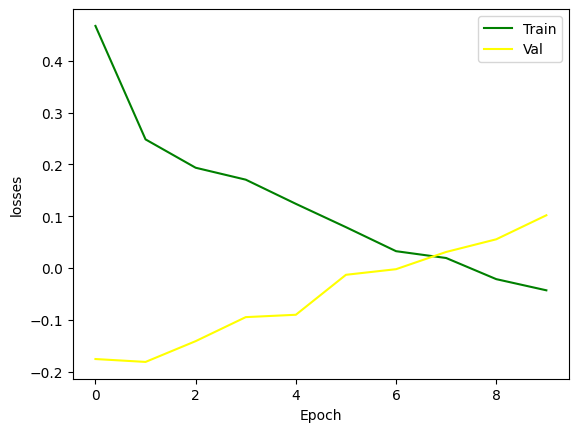

<Figure size 640x480 with 0 Axes>

-------------TRAINING END-------------


In [92]:

for lr, weight_decay, el, dl, d in parameter_pairs:
    model = TimeSeriesTransformerForPrediction(getConfig(el, dl, d))
    
    model, cur_best_train_score, cur_best_train_epoch, cur_best_val_score, cur_best_val_epoch =\
        train(model, train_dataloader, val_dataloader1, test_dataloader1, 10, lr, weight_decay, el, dl, d)
        
    if cur_best_train_score < best_train_loss:
        best_train_loss = cur_best_train_score
        best_train_epoch = cur_best_train_epoch
        best_train_lr = lr
        best_train_weight_decay = weight_decay
        best_train_el = el
        best_train_dl = dl
        best_train_d = d
        
    if cur_best_val_score < best_val_loss:
        best_val_loss = cur_best_val_score
        best_val_epoch = cur_best_val_epoch
        best_val_lr = lr    
        best_val_weight_decay = weight_decay
        best_val_el = el
        best_val_dl = dl
        best_val_d = d

In [93]:
print(f"Out of {numOfSearch} loop, \
    the best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}")
print(f"Out of {numOfSearch} loop, \
    the best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}")

with open("best_results.txt", "a") as f:
    f.write(f"Best training loss is {best_train_loss} at Epoch {best_train_epoch}, with lr:{best_train_lr} \
        wd:{best_train_weight_decay} el:{best_train_el} dl:{best_train_dl} d:{best_train_d}\n")
    f.write(f"Best validation loss is {best_val_loss} at Epoch {best_val_epoch}, with lr:{best_val_lr} \
        wd:{best_val_weight_decay} el:{best_val_el} dl:{best_val_dl} d:{best_val_d}\n")

Out of 18 loop,     the best training loss is -0.44050895869731904 at Epoch 9, with lr:0.0008020048559021621         wd:0.0008771906978684035 el:8 dl:16 d:64
Out of 18 loop,     the best validation loss is -0.22007377997040747 at Epoch 0, with lr:0.00046993387388781824         wd:0.0036220250677523502 el:16 dl:2 d:64


In [ ]:
best_val_loss

-0.23332787647843362

In [34]:
new_model_path = "saved_models/0.00046993387388781824-0.0036220250677523502-16-2-64/state/0"
new_model = TimeSeriesTransformerForPrediction(getConfig(16, 2, 64))
new_model.load_state_dict(torch.load(new_model_path))
new_model.eval()

old_model_path = "saved_models/0.0006-0.1/state/4"
old_model = TimeSeriesTransformerForPrediction(getConfig(4, 4, 32))
old_model.load_state_dict(torch.load(old_model_path))
old_model.eval()

TimeSeriesTransformerForPrediction(
  (model): TimeSeriesTransformerModel(
    (scaler): TimeSeriesStdScaler()
    (embedder): TimeSeriesFeatureEmbedder(
      (embedders): ModuleList(
        (0): Embedding(553, 2)
      )
    )
    (encoder): TimeSeriesTransformerEncoder(
      (value_embedding): TimeSeriesValueEmbedding(
        (value_projection): Linear(in_features=26, out_features=32, bias=False)
      )
      (embed_positions): TimeSeriesSinusoidalPositionalEmbedding(72, 32)
      (layers): ModuleList(
        (0): TimeSeriesTransformerEncoderLayer(
          (self_attn): TimeSeriesTransformerAttention(
            (k_proj): Linear(in_features=32, out_features=32, bias=True)
            (v_proj): Linear(in_features=32, out_features=32, bias=True)
            (q_proj): Linear(in_features=32, out_features=32, bias=True)
            (out_proj): Linear(in_features=32, out_features=32, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_af

In [35]:
def evaluate(model, data_loader):
    model.eval()

    forecasts = []

    for batch in data_loader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts.append(outputs.sequences.cpu().numpy())
        
    forecasts = np.vstack(forecasts)
    return forecasts


In [36]:

# forecasts = evaluate(model, test_dataloader)
old_forecasts = evaluate(old_model, test_dataloader)
new_forecasts = evaluate(new_model, test_dataloader)

In [38]:
from evaluate import load
from gluonts.time_feature import get_seasonality
def calculate(forecasts, dataset):

    mse_metric = load("evaluate-metric/mse")
    mase_metric = load("evaluate-metric/mase")
    smape_metric = load("evaluate-metric/smape")

    forecast_median = np.median(forecasts, 1)

    mse_metrics = []
    mase_metrics = []
    smape_metrics = []
    for item_id, ts in enumerate(dataset):
        training_data = ts["target"][:-prediction_length]
        ground_truth = ts["target"][-prediction_length:]
        mse = mse_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth)
            )
        mse_metrics.append(mse["mse"])
        
        mase = mase_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
            training=np.array(training_data), 
            periodicity=get_seasonality(freq))
        mase_metrics.append(mase["mase"])
        
        smape = smape_metric.compute(
            predictions=forecast_median[item_id], 
            references=np.array(ground_truth), 
        )
        smape_metrics.append(smape["smape"])
    
    return mse_metrics, mase_metrics, smape_metrics

# mse_metrics, mase_metrics, smape_metrics = calculate(forecasts, test_dataset)   
# print(f"Test MSE: {np.mean(mse_metrics)}")
# print(f"Test MASE: {np.mean(mase_metrics)}")
# print(f"Test sMAPE: {np.mean(smape_metrics)}")

mse_metrics, mase_metrics, smape_metrics = calculate(old_forecasts, test_dataset)   
mse_metrics2, mase_metrics2, smape_metrics2 = calculate(new_forecasts, test_dataset)   
print(f"Old Test MSE: {np.mean(mse_metrics)}")
print(f"New Test MSE: {np.mean(mse_metrics2)}")
print(f"Old Test MASE: {np.mean(mase_metrics)}")
print(f"New Test MASE: {np.mean(mase_metrics2)}")
print(f"Old Test sMAPE: {np.mean(smape_metrics)}")
print(f"New Test sMAPE: {np.mean(smape_metrics2)}")


Old Test MSE: 0.15607828248286146
New Test MSE: 0.12336296387841844
Old Test MASE: 1.6351721831303434
New Test MASE: 1.4843566336870326
Old Test sMAPE: 0.36068701603363706
New Test sMAPE: 0.3267852823059781


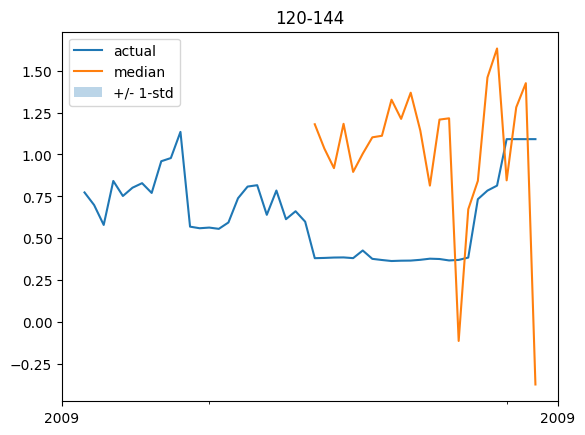

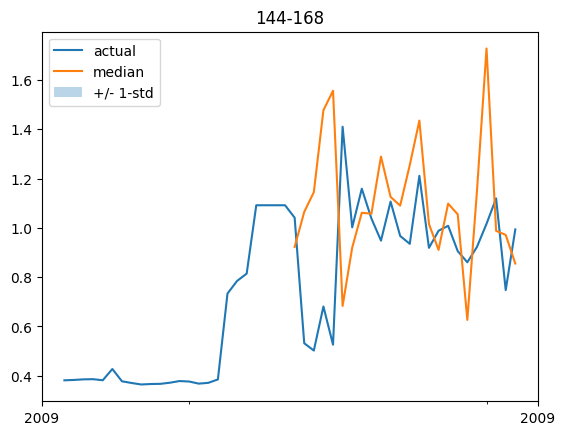

In [44]:
import matplotlib.dates as mdates

def plot(ts_index, forecasts):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.title(str(ts_index) + "-" + str(int(ts_index) + prediction_length))
    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.savefig("graph/new/" + str(ts_index) + "-" + str(int(ts_index) + prediction_length) + ".png")
    plt.legend()
    plt.show()
    
# plot(0, new_forecasts)
# plot(prediction_length, new_forecasts)
# plot(prediction_length * 2, new_forecasts)
# plot(prediction_length * 3, new_forecasts)
# plot(prediction_length * 4, new_forecasts)
# plot(prediction_length * 5, new_forecasts)
# plot(prediction_length * 6, new_forecasts)



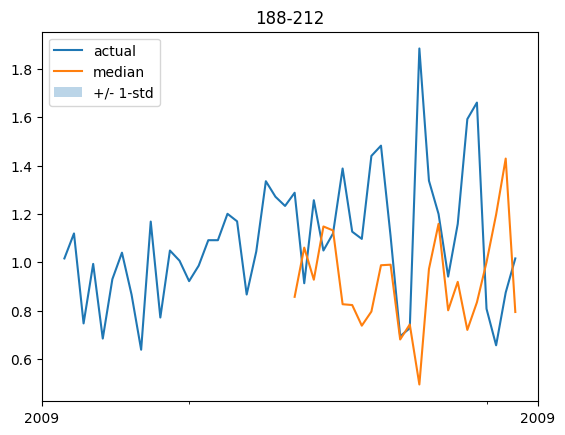

In [33]:
import random 

def plot_randomly(forecasts):
    plot(random.randint(0, len(forecasts) - 1), forecasts)
plot_randomly(forecasts)

In [ ]:

# # Try with epoch of 20 

# TODO: does the model's parameters reset when I pass it in the training loop again? FIND OUT
model = TimeSeriesTransformerForPrediction(config)
model = train(model, train_dataloader, 10)

-------------TRAINING START-------------
Training with epoch: 10
0.6526011824607849
0.3130802512168884
0.36704644560813904
0.21169684827327728
0.12620525062084198
0.4242374002933502
0.09392771869897842
0.255525678396225
0.14382927119731903
0.0988430455327034
-------------TRAINING END-------------


In [ ]:

forecasts_test = evaluate(model, test_dataloader) 

In [ ]:

train_dataloader_eval = create_test_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=64,
)
forecasts_train = evaluate(model, train_dataloader_eval)

In [ ]:

mse_metrics_train, mase_metrics_train, smape_metrics_train = calculate(forecasts_train, train_dataset)   

In [ ]:

 
mse_metrics_test, mase_metrics_test, smape_metrics_test = calculate(forecasts_test, test_dataset)  
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Test MSE: 0.14962979146346184
Test MASE: 1.634524162297278
Test sMAPE: 0.3614950069991882


In [ ]:

print(f"Train MSE: {np.mean(mse_metrics_train)}")
print(f"Test MSE: {np.mean(mse_metrics_test)}")
print(f"Train MASE: {np.mean(mase_metrics_train)}")
print(f"Test MASE: {np.mean(mase_metrics_test)}")
print(f"Train sMAPE: {np.mean(smape_metrics_train)}")
print(f"Test sMAPE: {np.mean(smape_metrics_test)}")

Train MSE: 0.1016107306770977
Test MSE: 0.07031509309540471
Train MASE: 0.9560396630533824
Test MASE: 1.1003828219742027
Train sMAPE: 0.27435744239020354
Test sMAPE: 0.23152500989246366


In [ ]:

plot(0, forecasts_train)
plot(prediction_length, forecasts_train)
plot(prediction_length * 2, forecasts_train)
plot(prediction_length * 3, forecasts_train)
plot(prediction_length * 4, forecasts_train)

NameError: name 'forecasts_train' is not defined

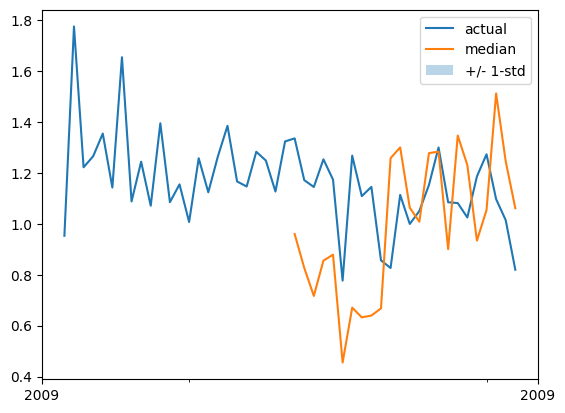

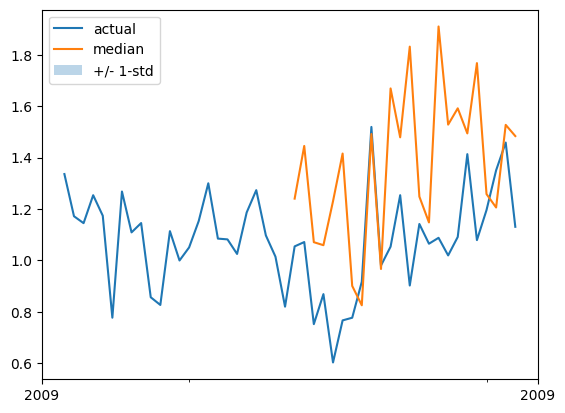

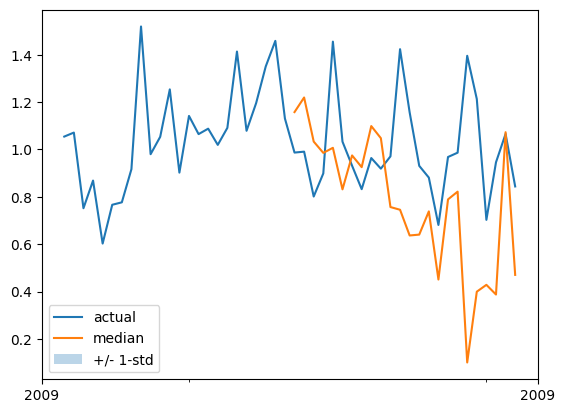

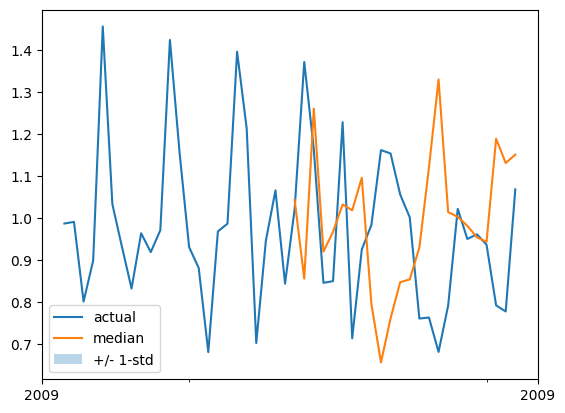

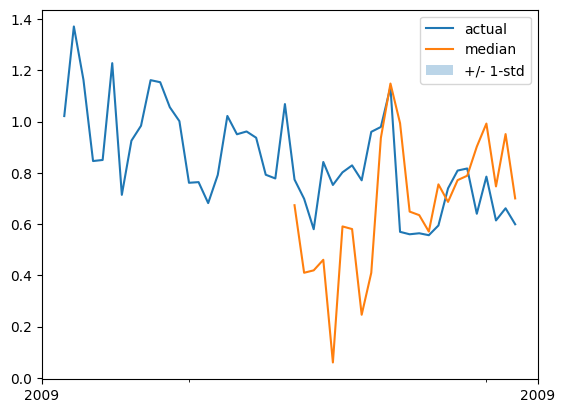

In [ ]:

plot(0, forecasts_test)
plot(prediction_length, forecasts_test)
plot(prediction_length * 2, forecasts_test)
plot(prediction_length * 3, forecasts_test)
plot(prediction_length * 4, forecasts_test)